In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Epoch 1/20


C:\Users\VPyrohov\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6361 - loss: 0.7473 - val_accuracy: 0.8857 - val_loss: 0.3306
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8825 - loss: 0.3087 - val_accuracy: 0.9257 - val_loss: 0.1620
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9536 - loss: 0.1482 - val_accuracy: 0.9905 - val_loss: 0.0687
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9668 - loss: 0.1153 - val_accuracy: 1.0000 - val_loss: 0.0291
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0538 - val_accuracy: 0.9886 - val_loss: 0.0305
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0452 - val_accuracy: 1.0000 - val_loss: 0.0124
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9907 - loss: 0.0305 - val_accuracy: 1.0000 - val_loss: 0.0137
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0271 - val_accuracy: 1.0000 - val_

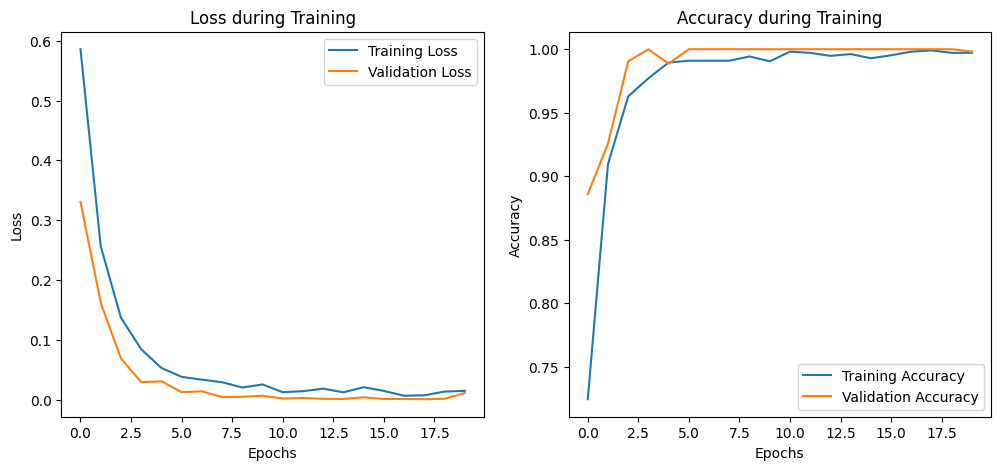

In [ ]:
# Function for loading data
def load_data(filenames, label):
    data = []
    labels = []
    for file in filenames:
        df = pd.read_csv(file, header=None)
        for i in range(len(df) - 125):  # Оконное разбиение (2.5 с * 50 Гц)
            window = df.iloc[i:i+125].values.flatten()
            data.append(window)
            labels.append(label)
    return np.array(data), np.array(labels)

# Loading data
gestures = {"circle": 0, "cross": 1, "pad": 2}
data = []
labels = []
for gesture, label in gestures.items():
    d, l = load_data([f"{gesture}.csv"], label)
    data.append(d)
    labels.append(l)

data = np.vstack(data)
labels = np.hstack(labels)

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Creating a model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(375,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model training
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

#Save the keras model after compiling
model.save('model_keras.h5')

# Visualization of learning
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss during Training')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy during Training')

plt.show()



In [ ]:
def representative_data_gen():
    for i_value in tf.data.Dataset.from_tensor_slices(X_test).batch(1).take(100):
        i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
        yield [i_value_f32]

# Load model from model_keras.h5 file
# model_keras= tf.keras.models.load_model('model_keras.h5')

# Conversion to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enable SELECT_TF_OPS support for LSTM
# converter.target_spec.supported_ops = [
#     tf.lite.OpsSet.TFLITE_BUILTINS, 
#     tf.lite.OpsSet.SELECT_TF_OPS
# ]

# Input/output type is left as float32
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

tflite_model = converter.convert()

# Save the model
with open("gesture_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\VPyrohov\AppData\Local\Temp\tmpq83uerbe\assets


INFO:tensorflow:Assets written to: C:\Users\VPyrohov\AppData\Local\Temp\tmpq83uerbe\assets


Saved artifact at 'C:\Users\VPyrohov\AppData\Local\Temp\tmpq83uerbe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 375), dtype=tf.float32, name='keras_tensor_45')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1926355713296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1926348166096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1926355710224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1926361477392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1926361477584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1926361465296: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
import tensorflow.lite as tflite  
import numpy as np  
import pandas as pd  

# Load data  
data = pd.read_csv("circle-test.csv", header=None)  

# Function for splitting into windows
def create_sequences(df, window_size=125):  # 125 * 3 = 375
    sequences = []
    for i in range(0, len(df) - window_size + 1, window_size):
        seq = df.iloc[i:i+window_size, :].values.flatten()  # Expand в 1D
        sequences.append(seq)
    return np.array(sequences)

# Now form X_new: (number of windows, 375)
sequences = []
sequences.append(data.values.flatten())  
X_new = np.array(sequences)
# print(X_new)


# Load TFLite model  
interpreter = tflite.Interpreter(model_path="gesture_model.tflite")  
interpreter.allocate_tensors()  
input_details = interpreter.get_input_details()


# We obtain input and output tensors
input_details = interpreter.get_input_details()  
output_details = interpreter.get_output_details()  
print(input_details[0]['dtype'])  
print(input_details[0]['quantization'])
print("Expected input shape:", input_details[0]['shape'])
print("Actual input shape:", data.shape)

# Prediction  
for i, window in enumerate(X_new):  
    input_data = np.expand_dims(window, axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)  
    interpreter.invoke()  
    output_data = interpreter.get_tensor(output_details[0]['index'])  
    print(f"Окно {i}: {output_data}")  


<class 'numpy.float32'>
(0.0, 0)
Expected input shape: [  1 375]
Actual input shape: (125, 3)
Окно 0: [[9.9744737e-01 2.5525119e-03 1.7783141e-07]]
